Optimized Parking Allocation (Indices): [11, 98, 10, 28, 99, 73, 38, 12, 22, 29, 65, 66, 53, 55, 44, 26, 84, 42, 63, 57, 86, 34, 45, 47, 24, 68, 43, 76, 62, 85, 72, 48, 54, 75, 23, 77, 74, 35, 52, 67, 27, 33, 64, 58, 37, 36, 32, 25, 56, 46]
Total Walking Distance: 102.16531938930531


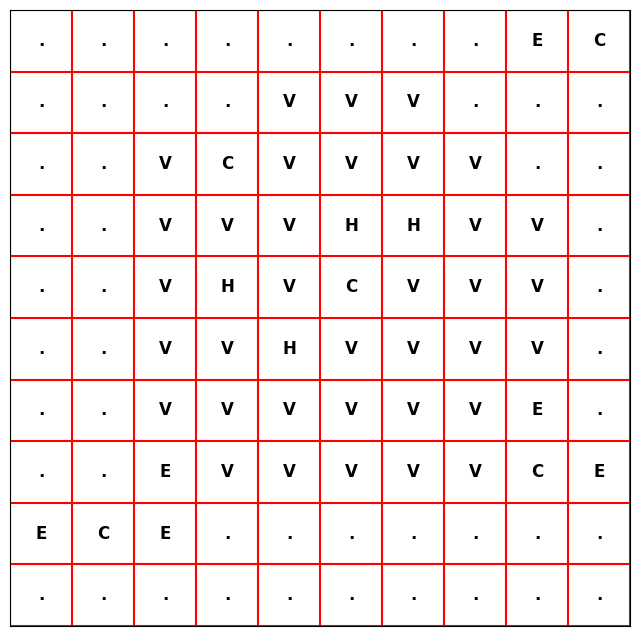

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Constants for  parking lot
GRID_DIM = 10
TOTAL_SPOTS = GRID_DIM * GRID_DIM  # 100 total parking spots
TOTAL_VEHICLES = 50
TOTAL_EV = 10
TOTAL_HANDICAP = 5
TOTAL_STANDARD = 35
CHARGE_POINTS = [(1, 1), (2, 8), (5, 5), (7, 3), (9, 9)]
MAIN_ENTRY = (5, 5)
POPULATION_SIZE = 100
MAX_GENERATIONS = 200
TOURNAMENT_POOL = 5
MUTATE_PROB = 0.2

# (row, column) position into a single index
def position_to_index(position):
    return position[0] * GRID_DIM + position[1]

#  index back to (row, column) position
def index_to_position(idx):
    return (idx // GRID_DIM, idx % GRID_DIM)

#  Euclidean distance between two points
def compute_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# a random initial chromosome  50 unique parking spots
def create_random_chromosome():
    available_lots = list(range(TOTAL_SPOTS))
    random.shuffle(available_lots)
    return available_lots[:TOTAL_VEHICLES]

# initial population of parking arrangements
def create_population(size):
    return [create_random_chromosome() for _ in range(size)]

# fitness func to evaluate parking arrangement
def evaluate_fitness(chromosome):
    total_walk_distance = 0
    penalty_score = 0

    for idx in range(TOTAL_VEHICLES):
        car_location = index_to_position(chromosome[idx])
        
        if idx < TOTAL_EV:  # EVs must be close to charging stations
            nearest_charge = min(compute_distance(car_location, station) for station in CHARGE_POINTS)
            total_walk_distance += nearest_charge
            if nearest_charge > 3:  # penalty if too far
                penalty_score += 10

        elif idx < TOTAL_EV + TOTAL_HANDICAP:  # Handicapped vehicles near entrance
            entry_distance = compute_distance(car_location, MAIN_ENTRY)
            total_walk_distance += entry_distance
            if entry_distance > 2:  #  penalty for distant spots
                penalty_score += 10

        else:  # Regular cars aim to minimize walking distance
            total_walk_distance += compute_distance(car_location, MAIN_ENTRY)

    return total_walk_distance + penalty_score

# Tournament-based selection of individuals
def select_via_tournament(population):
    subset = random.sample(population, TOURNAMENT_POOL)
    return min(subset, key=evaluate_fitness)

# Crossover function to create new solutions
def perform_crossover(parent_a, parent_b):
    offspring = [-1] * TOTAL_VEHICLES
    occupied_spots = set()

    for idx in range(TOTAL_VEHICLES):
        if random.random() < 0.5 and parent_a[idx] not in occupied_spots:
            offspring[idx] = parent_a[idx]
            occupied_spots.add(parent_a[idx])
        elif parent_b[idx] not in occupied_spots:
            offspring[idx] = parent_b[idx]
            occupied_spots.add(parent_b[idx])

    # Filling remaining spots with random available ones
    remaining_spots = list(set(range(TOTAL_SPOTS)) - occupied_spots)
    random.shuffle(remaining_spots)

    for idx in range(TOTAL_VEHICLES):
        if offspring[idx] == -1:
            offspring[idx] = remaining_spots.pop()

    return offspring

# Mutation function: swap two spots randomly
def apply_mutation(chromosome):
    if random.random() < MUTATE_PROB:
        swap_a, swap_b = random.sample(range(TOTAL_VEHICLES), 2)
        chromosome[swap_a], chromosome[swap_b] = chromosome[swap_b], chromosome[swap_a]
    return chromosome

# Genetic Algorithm to find an optimal parking arrangement
def optimize_parking():
    population_pool = create_population(POPULATION_SIZE)
    optimal_solution = min(population_pool, key=evaluate_fitness)
    best_distance_score = evaluate_fitness(optimal_solution)
    stagnant_counter = 0  # to Track if improvement stalls

    for generation in range(MAX_GENERATIONS):
        new_generation = []
        for _ in range(POPULATION_SIZE // 2):
            parent_one = select_via_tournament(population_pool)
            parent_two = select_via_tournament(population_pool)
            offspring_one = perform_crossover(parent_one, parent_two)
            offspring_two = perform_crossover(parent_two, parent_one)
            new_generation.extend([apply_mutation(offspring_one), apply_mutation(offspring_two)])
        
        population_pool = new_generation
        current_best = min(population_pool, key=evaluate_fitness)
        current_best_score = evaluate_fitness(current_best)

        if current_best_score < best_distance_score:
            optimal_solution = current_best
            best_distance_score = current_best_score
            stagnant_counter = 0  # Reset stagnation tracker
        else:
            stagnant_counter += 1

        if stagnant_counter >= 20:  # Stop early if no improvements
            break

    return optimal_solution, best_distance_score

# the Genetic Algorithm
best_parking_setup, min_walking_distance = optimize_parking()

# Visualizing the final parking arrangement
def display_parking_arrangement(solution):
    parking_grid = np.zeros((GRID_DIM, GRID_DIM), dtype=str)

    # mark all spaces as empty
    parking_grid[:, :] = "."

    # Assign vehicles to parking spots
    for idx in range(TOTAL_VEHICLES):
        r, c = index_to_position(solution[idx])
        if idx < TOTAL_EV:
            parking_grid[r, c] = "E"  # Electric Vehicle
        elif idx < TOTAL_EV + TOTAL_HANDICAP:
            parking_grid[r, c] = "H"  # Handicapped Parking
        else:
            parking_grid[r, c] = "V"  # Regular Vehicle

    # the entrance and charging stations
    parking_grid[MAIN_ENTRY] = "X"  # Entrance
    for station in CHARGE_POINTS:
        parking_grid[station] = "C"  # Charging Station

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks(np.arange(-0.5, GRID_DIM, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, GRID_DIM, 1), minor=True)
    ax.grid(which="minor", color="red", linestyle='-', linewidth=1.5)
    ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    
    # Display grid with assigned spots
    for i in range(GRID_DIM):
        for j in range(GRID_DIM):
            ax.text(j, i, parking_grid[i, j], ha='center', va='center', fontsize=12, fontweight='bold')

    plt.show()

# Display results
print("Optimized Parking Allocation (Indices):", best_parking_setup)
print("Total Walking Distance:", min_walking_distance)
display_parking_arrangement(best_parking_setup)


In [2]:
import random

#  different investment strategies with return, drawdown, and risk levels
investment_strategies = {
    1: {'profit': 0.5, 'loss': -1, 'risk_level': 1},
    2: {'profit': 1.2, 'loss': -2.5, 'risk_level': 2},
    3: {'profit': 2.5, 'loss': -5, 'risk_level': 3},
    4: {'profit': 5, 'loss': -10, 'risk_level': 4},
    5: {'profit': 10, 'loss': -15, 'risk_level': 5},
}

#  a valid trading strategy sequence
def create_strategy_sequence():
    
    sequence = []
    previous_choice = None
    for _ in range(30):
        options = list(investment_strategies.keys())
        if previous_choice is not None:
            options = [s for s in options if s != previous_choice]
        selected_strategy = random.choice(options)
        sequence.append(selected_strategy)
        previous_choice = selected_strategy
    return sequence

# Repair function to fix consecutive duplicates
def fix_strategy_sequence(sequence):
    
    for i in range(1, len(sequence)):
        if sequence[i] == sequence[i - 1]:
            valid_choices = [s for s in investment_strategies if s != sequence[i - 1]]
            if i < len(sequence) - 1:
                valid_choices = [s for s in valid_choices if s != sequence[i + 1]]
            sequence[i] = random.choice(valid_choices) if valid_choices else sequence[i]
    return sequence

#  the fitness of a given strategy sequence
def evaluate_fitness(sequence):
    
    total_profit = sum(investment_strategies[s]['profit'] for s in sequence)
    cumulative_loss = sum(investment_strategies[s]['loss'] for s in sequence)
    
    #penalties for high drawdowns and consecutive repeats
    single_day_penalty = sum(10 for s in sequence if investment_strategies[s]['loss'] < -15)
    consecutive_repeat_penalty = sum(5 for i in range(1, len(sequence)) if sequence[i] == sequence[i - 1])
    cumulative_loss_penalty = 20 if cumulative_loss < -30 else 0

    final_score = total_profit - single_day_penalty - consecutive_repeat_penalty - cumulative_loss_penalty
    return (final_score, total_profit, cumulative_loss, consecutive_repeat_penalty // 5, single_day_penalty // 10)

# Select parents using tournament selection
def perform_tournament_selection(population, fitness_scores, selection_size=5):
    
    selected_parents = []
    for _ in range(len(population) // 2):
        contenders = random.sample(list(zip(population, fitness_scores)), selection_size)
        contenders.sort(key=lambda x: x[1][0], reverse=True)
        selected_parents.extend([contenders[0][0], contenders[1][0]])
    return selected_parents

# Single-point crossover to produce offspring
def apply_crossover(parent1, parent2):
    
    crossover_point = random.randint(1, 28)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return [fix_strategy_sequence(child1), fix_strategy_sequence(child2)]

# Mutation function ensuring no consecutive repeats
def apply_mutation(sequence, mutation_probability=0.05):
    
    mutated_sequence = []
    previous_strategy = None
    for strategy in sequence:
        if random.random() < mutation_probability:
            options = [s for s in investment_strategies if s != previous_strategy]
            mutated_sequence.append(random.choice(options))
            previous_strategy = mutated_sequence[-1]
        else:
            mutated_sequence.append(strategy)
            previous_strategy = strategy
    return fix_strategy_sequence(mutated_sequence)

#  risk factors of a given sequence
def assess_risk(sequence):
    
    daily_losses = [investment_strategies[s]['loss'] for s in sequence]
    worst_single_day = min(daily_losses)
    high_risk_day_count = sum(1 for loss in daily_losses if loss < -15)
    average_risk_level = sum(investment_strategies[s]['risk_level'] for s in sequence) / len(sequence)
    
    return {
        'daily_losses': daily_losses,
        'worst_single_day': worst_single_day,
        'high_risk_days': high_risk_day_count,
        'average_risk_level': average_risk_level
    }

#  genetic algorithm execution
def main():
    random.seed(42)
    population = [create_strategy_sequence() for _ in range(100)]
    
    for generation in range(100):
        #  fitness for  entire population
        fitness_results = [evaluate_fitness(strategy) for strategy in population]
        
        #  the best individuals as parents
        selected_parents = perform_tournament_selection(population, fitness_results)
        
        # new offspring via crossover
        new_population = []
        for i in range(0, len(selected_parents), 2):
            offspring1, offspring2 = apply_crossover(selected_parents[i], selected_parents[i + 1])
            new_population.extend([offspring1, offspring2])
        
        # Apply mutation to maintain diversity
        population = [apply_mutation(strategy) for strategy in new_population]
        
        # Track progress every 10 generations
        if generation % 10 == 0:
            best_fitness = max(f[0] for f in fitness_results)
            print(f"Generation {generation}: Best Fitness = {best_fitness:.1f}")
    
    # Final evaluation of  best strategy
    best_strategy = max(population, key=lambda s: evaluate_fitness(s)[0])
    fit_score, total_profit, total_loss, repeat_penalty, drawdown_penalty = evaluate_fitness(best_strategy)
    risk_analysis = assess_risk(best_strategy)
    
    print("\n===    The   Optimal Trading Strategy    ===")
    print("Strategy Sequence:", best_strategy)
    print(f"\nTotal Profit: {total_profit:.1f}%")
    print(f"Cumulative Drawdown: {total_loss:.1f}%")
    print(f"Consecutive Repeats: {repeat_penalty} (Penalty: {repeat_penalty * 5}%)")
    print(f"Single-Day Drawdown Violations: {drawdown_penalty} (Penalty: {drawdown_penalty * 10}%)")
    print(f"Final Fitness Score: {fit_score:.1f}%")
    
    print("\n===   Risk Analysis   ===")
    print(f"Maximum Single-Day Drawdown: {risk_analysis['worst_single_day']}%")
    print(f"Days Exceeding -15% Drawdown: {risk_analysis['high_risk_days']}")
    print(f"Average Risk Level: {risk_analysis['average_risk_level']:.1f}/5")
    print("Daily Drawdowns:", [f"{loss}%" for loss in risk_analysis['daily_losses']])

if __name__ == "__main__":
    main()


Generation 0: Best Fitness = 132.3
Generation 10: Best Fitness = 177.9
Generation 20: Best Fitness = 187.4
Generation 30: Best Fitness = 197.4
Generation 40: Best Fitness = 202.5
Generation 50: Best Fitness = 205.0
Generation 60: Best Fitness = 205.0
Generation 70: Best Fitness = 205.0
Generation 80: Best Fitness = 205.0
Generation 90: Best Fitness = 205.0

===    The   Optimal Trading Strategy    ===
Strategy Sequence: [5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4]

Total Profit: 225.0%
Cumulative Drawdown: -375.0%
Consecutive Repeats: 0 (Penalty: 0%)
Single-Day Drawdown Violations: 0 (Penalty: 0%)
Final Fitness Score: 205.0%

===   Risk Analysis   ===
Maximum Single-Day Drawdown: -15%
Days Exceeding -15% Drawdown: 0
Average Risk Level: 4.5/5
Daily Drawdowns: ['-15%', '-10%', '-15%', '-10%', '-15%', '-10%', '-15%', '-10%', '-15%', '-10%', '-15%', '-10%', '-15%', '-10%', '-15%', '-10%', '-15%', '-10%', '-15%', '-10%', '-15%', '-10%', '-15%', 

Best Escape Strategy: ['Advance', 'Retreat', 'Sprint', 'Sprint', 'Sprint', 'Advance', 'High Leap', 'Advance', 'Advance', 'Descend', 'Descend', 'High Leap', 'Sprint', 'Sprint', 'Retreat', 'High Leap', 'Descend', 'Descend', 'Leap', 'Advance', 'Advance', 'Descend', 'Sprint', 'Leap', 'High Leap', 'Retreat', 'Sprint', 'Sprint', 'Descend', 'Leap', 'Descend', 'Retreat', 'Retreat', 'Leap', 'Descend', 'Retreat', 'Sprint', 'Advance', 'Advance', 'Leap', 'Retreat', 'Retreat', 'Retreat', 'Descend', 'Sprint', 'Descend', 'Retreat', 'Leap', 'Retreat', 'Advance', 'High Leap', 'Leap', 'Advance', 'Sprint', 'Advance', 'Advance', 'Retreat', 'Descend', 'Sprint', 'Leap', 'Descend', 'Advance', 'Sprint', 'High Leap', 'Descend', 'Retreat', 'Leap', 'Sprint', 'Sprint', 'Leap']
Best Fitness Score: 12


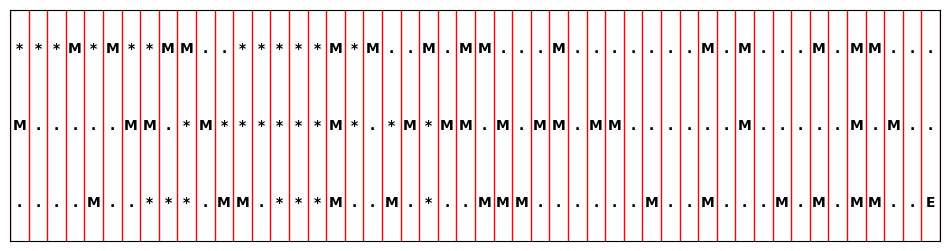

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Grid Configuration
GRID_ROWS, GRID_COLS = 3, 50
MAFIA_ZONES = int(0.3 * (GRID_ROWS * GRID_COLS))  # 30% of the grid occupied by mafia
START_POINT = (2, 0)  # Bottom-left corner
EXIT_POINT = (0, 49)  # Top-right corner
MAX_STEPS = 70
POPULATION_SIZE = 10
MAX_GENERATIONS = 100
MUTATION_PROB = 0.1  # Mutation probability (adjustable between 5-25%)

#  movement options
ACTIONS = ["Advance", "Retreat", "Leap", "Descend", "High Leap", "Sprint"]

# Movement mapping (row, col) changes
ACTION_MAP = {
    "Advance": (0, 1),  # Move right
    "Retreat": (0, -1),  # Move left
    "Leap": (-1, 0),  # Move up
    "Descend": (1, 0),  # Move down
    "High Leap": (-2, 0),  # Move two steps up
    "Sprint": (0, 2)  # Move two steps right
}

# the grid with mafia block locations
def create_grid():
    grid = np.zeros((GRID_ROWS, GRID_COLS), dtype=int)  # 0 = open, 1 = mafia zone
    mafia_positions = random.sample([(r, c) for r in range(GRID_ROWS) for c in range(GRID_COLS)
                                     if (r, c) not in [START_POINT, EXIT_POINT]], MAFIA_ZONES)
    for pos in mafia_positions:
        grid[pos] = 1  # Mark mafia presence
    return grid

# Generate a random movement sequence (chromosome)
def create_chromosome():
    return [random.choice(ACTIONS) for _ in range(MAX_STEPS)]

# Generate an initial population of movement sequences
def initialize_population(size):
    return [create_chromosome() for _ in range(size)]

# Validate if a movement is possible
def validate_move(position, action, grid):
    new_row, new_col = position[0] + ACTION_MAP[action][0], position[1] + ACTION_MAP[action][1]
    if 0 <= new_row < GRID_ROWS and 0 <= new_col < GRID_COLS and grid[new_row, new_col] != 1:
        return (new_row, new_col)  # Valid movement
    return position  # Invalid move

#  fitness of a given movement sequence
def compute_fitness(chromosome, grid):
    current_position = START_POINT
    step_count = 0
    invalid_penalty = 0

    for action in chromosome:
        new_position = validate_move(current_position, action, grid)
        if new_position == current_position:
            invalid_penalty += 1  # Penalize invalid moves
        current_position = new_position
        step_count += 1
        if current_position == EXIT_POINT:
            break  # Successfully escaped

    #  fitness score based on movement efficiency
    distance_remaining = abs(current_position[0] - EXIT_POINT[0]) + abs(current_position[1] - EXIT_POINT[1])
    fitness_score = (GRID_ROWS + GRID_COLS) - distance_remaining - invalid_penalty

    if current_position == EXIT_POINT:
        fitness_score += 100  # Bonus for successful escape

    return fitness_score

# Tournament selection to choose the best candidates
def select_by_tournament(population, grid):
    candidates = random.sample(population, 5)  # Select 5 random sequences
    return max(candidates, key=lambda chromo: compute_fitness(chromo, grid))

# Perform crossover between two parents to create offspring
def perform_crossover(parent_a, parent_b):
    crossover_point = random.randint(1, MAX_STEPS - 2)
    offspring_1 = parent_a[:crossover_point] + parent_b[crossover_point:]
    offspring_2 = parent_b[:crossover_point] + parent_a[crossover_point:]
    return offspring_1, offspring_2

#  mutation by randomly altering moves in a sequence
def apply_mutation(chromosome):
    for i in range(MAX_STEPS):
        if random.random() < MUTATION_PROB:
            chromosome[i] = random.choice(ACTIONS)
    return chromosome

# the genetic algorithm for optimal pathfinding
def run_genetic_algorithm():
    grid = create_grid()
    population = initialize_population(POPULATION_SIZE)
    best_solution = max(population, key=lambda chromo: compute_fitness(chromo, grid))
    highest_fitness = compute_fitness(best_solution, grid)

    for generation in range(MAX_GENERATIONS):
        new_population = []
        
        for _ in range(POPULATION_SIZE // 2):
            parent_a = select_by_tournament(population, grid)
            parent_b = select_by_tournament(population, grid)
            offspring_1, offspring_2 = perform_crossover(parent_a, parent_b)
            new_population.extend([apply_mutation(offspring_1), apply_mutation(offspring_2)])

        population = new_population
        current_best = max(population, key=lambda chromo: compute_fitness(chromo, grid))
        current_fitness = compute_fitness(current_best, grid)

        if current_fitness > highest_fitness:
            best_solution = current_best
            highest_fitness = current_fitness

    return best_solution, highest_fitness, grid

#  the genetic algorithm
optimal_solution, optimal_fitness, mafia_territory = run_genetic_algorithm()

# Visualize the grid and the chosen escape route
def display_grid(grid, path):
    grid_representation = np.full((GRID_ROWS, GRID_COLS), ".", dtype=str)

    # Mark mafia zones
    for r in range(GRID_ROWS):
        for c in range(GRID_COLS):
            if grid[r, c] == 1:
                grid_representation[r, c] = "M"  # Mafia block

    # Mark starting and exit positions
    grid_representation[START_POINT] = "S"
    grid_representation[EXIT_POINT] = "E"

    # Mark the escape route taken
    current_position = START_POINT
    for action in path:
        new_position = validate_move(current_position, action, grid)
        if new_position == EXIT_POINT:
            break
        grid_representation[new_position] = "*"
        current_position = new_position

    # the grid representation
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.set_xticks(np.arange(-0.5, GRID_COLS, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, GRID_ROWS, 1), minor=True)
    ax.grid(which="minor", color="red", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    
    for i in range(GRID_ROWS):
        for j in range(GRID_COLS):
            ax.text(j, i, grid_representation[i, j], ha='center', va='center', fontsize=10, fontweight='bold')

    plt.show()

# Display final results
print("Best Escape Strategy:", optimal_solution)
print("Best Fitness Score:", optimal_fitness)
display_grid(mafia_territory, optimal_solution)


In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ------------------
# GA CONFIGURATIONS
# ------------------
TOTAL_SPOTS = 50
TOTAL_DAYS = 5
DAILY_HOURS = 8
MAX_SPOTS_PER_DAY = 10
GROUP_SIZE = 100
MAX_CYCLES = 200
MUTATE_PROB = 0.1  # 10% mutation rate
SELECTION_SIZE = 5  # for tournament selection

# ------------------
# DATA GENERATION
# ------------------
np.random.seed(42)

# Generate random spots (cost, popularity, duration)
tourist_spots = [
    {
        "id": i,
        "name": f"Spot {i+1}",
        "cost": np.random.randint(5, 50),      # Entry cost between $5 - $50
        "popularity": np.random.randint(1, 11),# Popularity rating (1-10)
        "duration": np.random.randint(1, 4),   # Visit duration (1-3 hours)
    }
    for i in range(TOTAL_SPOTS)
]

# random travel-time matrix (5 to 60 minutes, converted to hours)
commute_times = np.random.randint(5, 61, size=(TOTAL_SPOTS, TOTAL_SPOTS)) / 60
np.fill_diagonal(commute_times, 0)  # No travel time for the same location

# ------------------
# CHROMOSOME UTILITIES
# ------------------
def create_plan():
    available_spots = list(range(TOTAL_SPOTS))
    random.shuffle(available_spots)
    
    schedule = [sorted(available_spots[i::TOTAL_DAYS][:MAX_SPOTS_PER_DAY]) for i in range(TOTAL_DAYS)]
    return schedule

def fix_plan(plan):
    visited = set()
    for day_idx in range(TOTAL_DAYS):
        new_day = []
        for spot in plan[day_idx]:
            if spot not in visited:
                visited.add(spot)
                new_day.append(spot)
        plan[day_idx] = new_day
    return plan

def adjust_plan(plan):
    for day in range(TOTAL_DAYS):
        while True:
            total_time = sum(tourist_spots[s]["duration"] for s in plan[day])
            travel_time = sum(
                commute_times[plan[day][i - 1]][plan[day][i]]
                for i in range(1, len(plan[day]))
            )
            total_time += travel_time

            if total_time <= DAILY_HOURS:
                break  

            lowest_ratio_spot = min(
                plan[day],
                key=lambda s: tourist_spots[s]["popularity"] / tourist_spots[s]["duration"]
            )
            plan[day].remove(lowest_ratio_spot)

        used_spots = set(sum(plan, []))
        available_spots = sorted(
            (s for s in range(TOTAL_SPOTS) if s not in used_spots),
            key=lambda s: tourist_spots[s]["popularity"] / tourist_spots[s]["duration"],
            reverse=True
        )

        for s in available_spots:
            day_time = sum(tourist_spots[a]["duration"] for a in plan[day])
            travel_time = sum(
                commute_times[plan[day][i - 1]][plan[day][i]]
                for i in range(1, len(plan[day]))
            )
            if day_time + travel_time + tourist_spots[s]["duration"] <= DAILY_HOURS:
                plan[day].append(s)
            else:
                break

    return plan

# ------------------
# FITNESS FUNCTION
# ------------------
def evaluate_fitness(plan):
    total_fun = 0
    total_expense = 0
    penalty = 0
    visited_spots = set()

    for day_schedule in plan:
        day_time = 0

        for i, spot_id in enumerate(day_schedule):
            if spot_id in visited_spots:
                penalty += 100  
            else:
                visited_spots.add(spot_id)

            spot_info = tourist_spots[spot_id]
            total_fun += spot_info["popularity"]
            total_expense += spot_info["cost"]
            day_time += spot_info["duration"]

            if i > 0:
                prev_id = day_schedule[i - 1]
                day_time += commute_times[prev_id][spot_id]

        if day_time > DAILY_HOURS:
            penalty += (day_time - DAILY_HOURS) * 200

    return total_fun - (total_expense / 10) - penalty

# ------------------
# GA OPERATORS
# ------------------
def select_best(population, k=SELECTION_SIZE):
    candidates = random.sample(population, k)
    return max(candidates, key=evaluate_fitness)

def cross_plans(parent1, parent2):
    swap_point = random.randint(1, TOTAL_DAYS - 1)
    child1 = parent1[:swap_point] + parent2[swap_point:]
    child2 = parent2[:swap_point] + parent1[swap_point:]
    
    child1 = fix_plan(child1)
    child2 = fix_plan(child2)
    
    return child1, child2

def modify_plan(plan):
    for day in range(TOTAL_DAYS):
        if random.random() < MUTATE_PROB and plan[day]:
            used_spots = set(sum(plan, []))
            available_spots = list(set(range(TOTAL_SPOTS)) - used_spots)
            if available_spots:
                swap_index = random.randint(0, len(plan[day]) - 1)
                plan[day][swap_index] = random.choice(available_spots)
    return plan

# ------------------
# MAIN GA FUNCTION
# ------------------
def run_ga():
    population = [create_plan() for _ in range(GROUP_SIZE)]
    population = [adjust_plan(fix_plan(p)) for p in population]

    best_schedule = max(population, key=evaluate_fitness)
    highest_fitness = evaluate_fitness(best_schedule)

    for cycle in range(MAX_CYCLES):
        new_population = []
        for _ in range(GROUP_SIZE // 2):
            parent1 = select_best(population, SELECTION_SIZE)
            parent2 = select_best(population, SELECTION_SIZE)
            
            child1, child2 = cross_plans(parent1, parent2)
            
            child1 = modify_plan(child1)
            child2 = modify_plan(child2)
            
            child1 = adjust_plan(fix_plan(child1))
            child2 = adjust_plan(fix_plan(child2))
            
            new_population.extend([child1, child2])

        population = new_population
        best_schedule = max(population, key=evaluate_fitness)
        highest_fitness = evaluate_fitness(best_schedule)

    return best_schedule, highest_fitness

# ------------------
#  RESULTS
# ------------------
def display_schedule(solution, best_fitness):
    print("\n=== Optimized 5-Day Schedule ===")
    total_expense = 0
    total_fun = 0

    for day, daily_plan in enumerate(solution, 1):
        print(f"\nDay {day}:")
        day_expense = 0
        day_fun = 0

        for spot_id in daily_plan:
            spot = tourist_spots[spot_id]
            print(f"  - {spot['name']} (Cost: ${spot['cost']}, Rating: {spot['popularity']}/10, Time: {spot['duration']} hrs)")
            day_expense += spot["cost"]
            day_fun += spot["popularity"]

        print(f"  Total Day Cost: ${day_expense} | Total Enjoyment: {day_fun}")
        total_expense += day_expense
        total_fun += day_fun

    print("\n=== Summary ===")
    print(f"Total Enjoyment Score: {total_fun}")
    print(f"Total Cost: ${total_expense}")
    print(f"Fitness Score: {best_fitness:.2f}")

# ------------------
# RUN THE GA
# ------------------
if __name__ == "__main__":
    best_schedule, best_fitness = run_ga()
    display_schedule(best_schedule, best_fitness)



=== Optimized 5-Day Schedule ===

Day 1:
  - Spot 26 (Cost: $35, Rating: 8/10, Time: 2 hrs)
  - Spot 30 (Cost: $29, Rating: 9/10, Time: 1 hrs)
  - Spot 41 (Cost: $39, Rating: 8/10, Time: 2 hrs)
  - Spot 49 (Cost: $36, Rating: 7/10, Time: 1 hrs)
  - Spot 17 (Cost: $13, Rating: 10/10, Time: 1 hrs)
  Total Day Cost: $152 | Total Enjoyment: 42

Day 2:
  - Spot 11 (Cost: $31, Rating: 10/10, Time: 3 hrs)
  - Spot 37 (Cost: $43, Rating: 10/10, Time: 1 hrs)
  - Spot 5 (Cost: $15, Rating: 8/10, Time: 1 hrs)
  - Spot 38 (Cost: $32, Rating: 7/10, Time: 1 hrs)
  Total Day Cost: $121 | Total Enjoyment: 35

Day 3:
  - Spot 28 (Cost: $44, Rating: 5/10, Time: 1 hrs)
  - Spot 45 (Cost: $9, Rating: 10/10, Time: 3 hrs)
  - Spot 23 (Cost: $8, Rating: 6/10, Time: 1 hrs)
  - Spot 10 (Cost: $26, Rating: 9/10, Time: 1 hrs)
  - Spot 40 (Cost: $27, Rating: 8/10, Time: 1 hrs)
  Total Day Cost: $114 | Total Enjoyment: 38

Day 4:
  - Spot 2 (Cost: $19, Rating: 8/10, Time: 1 hrs)
  - Spot 12 (Cost: $48, Rating: 7/